# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [117]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import operator
from sklearn.preprocessing import StandardScaler, Imputer
# newer version 
#from sklearn.preprocessing import Imputer
#from sklearn.impute import SimpleImputer
#from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [118]:
# Load in the general demographics data.
azdias = pd.read_csv('./Udacity_AZDIAS_Subset.csv',delimiter = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('./AZDIAS_Feature_Summary.csv', delimiter = ';')

In [119]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

azdias.head(2)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0


In [120]:
#checking shape 

azdias.shape

(891221, 85)

In [121]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [122]:
#checking how many have NaN as a sum

azdias.isna().sum()

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [123]:
feat_info.head(2)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"


In [124]:
feat_info.shape

(85, 4)

In [125]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [126]:
# Identify missing or unknown data values and convert them to NaNs.

#checking out columns to read more easily

column_names = azdias.columns
column_names


Index(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
       'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE',
       'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT',
       'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT',
       'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP',
       'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE',
       'KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_

In [127]:
# all columns that have missing or unknown data

unknown = feat_info['missing_or_unknown']
unknown

0       [-1,0]
1     [-1,0,9]
2       [-1,0]
3          [0]
4         [-1]
5         [-1]
6         [-1]
7         [-1]
8         [-1]
9         [-1]
10        [-1]
11         [0]
12          []
13          []
14      [-1,0]
15         [0]
16         [0]
17         [0]
18         [0]
19         [0]
20         [0]
21      [-1,0]
22      [-1,0]
23         [0]
24      [-1,9]
25      [-1,9]
26      [-1,9]
27      [-1,9]
28      [-1,9]
29      [-1,9]
        ...   
55        [-1]
56        [-1]
57      [-1,X]
58        [XX]
59     [-1,XX]
60        [-1]
61        [-1]
62        [-1]
63        [-1]
64      [-1,0]
65      [-1,0]
66        [-1]
67        [-1]
68        [-1]
69          []
70      [-1,0]
71          []
72          []
73      [-1,0]
74          []
75        [-1]
76        [-1]
77        [-1]
78        [-1]
79      [-1,0]
80        [-1]
81        [-1]
82      [-1,9]
83      [-1,0]
84      [-1,9]
Name: missing_or_unknown, Length: 85, dtype: object

In [128]:
# convert missing/unknown values to nan function


def convert_missing_to_nan(df):
    for i,item in zip(range(len(df)), df.iteritems()): #zip is needed to keep tuple shape with range
        missing_unknown = feat_info['missing_or_unknown'][i]
        missing_unknown = missing_unknown[1:-1].split(',') #as noted from above cell
        column_name = item[0]
        if missing_unknown != ['']:
            miss = [x if x in ['X','XX'] else int(x) for x in missing_unknown] #some have X, XX. 
            
            df[column_name] = df[column_name].replace(miss,np.nan)
            
    return df, missing_unknown

azdias,  missing_unknown = convert_missing_to_nan(azdias)

In [129]:
azdias.isnull().sum()

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [130]:
#dropping the NA and keeping that shape of 85
azdias.dropna(how='any').shape, azdias.dropna(how='all').shape

((143, 85), (891221, 85))

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [131]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

missing_column_amount = azdias.isnull().sum()
missing_column_amount

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [132]:
# selecting columns with missing values > 0 and resorting them. 
missing_column_above_zero = missing_column_amount[missing_column_amount > 0]

missing_column_above_zero.sort_values(inplace=True, ascending=False)
missing_column_above_zero


TITEL_KZ                 889061
AGER_TYP                 685843
KK_KUNDENTYP             584612
KBA05_BAUMAX             476524
GEBURTSJAHR              392318
ALTER_HH                 310267
REGIOTYP                 158064
KKK                      158064
W_KEIT_KIND_HH           147988
KBA05_ANTG4              133324
KBA05_GBZ                133324
MOBI_REGIO               133324
KBA05_ANTG1              133324
KBA05_ANTG2              133324
KBA05_ANTG3              133324
PLZ8_GBZ                 116515
PLZ8_HHZ                 116515
PLZ8_BAUMAX              116515
PLZ8_ANTG4               116515
PLZ8_ANTG1               116515
PLZ8_ANTG3               116515
PLZ8_ANTG2               116515
SHOPPER_TYP              111196
VERS_TYP                 111196
HEALTH_TYP               111196
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
KBA13_ANZAHL_PKW         105800
ANZ_HAUSHALTE_AKTIV       99611
CAMEO_INTL_2015           99352
                          ...  
CAMEO_DE

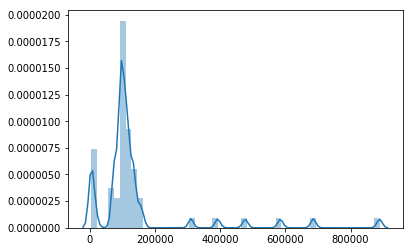

In [133]:
#plotting the distribution of the missing columns above zero
sns.distplot(missing_column_above_zero)

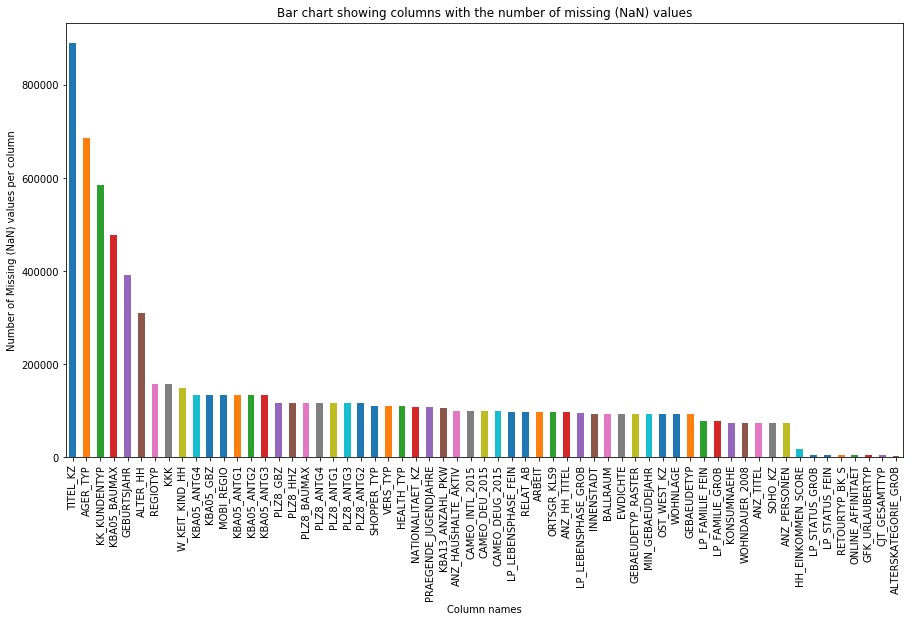

There are 61 columns with missing (NaN) values.


In [134]:
#now lets see the total volumns by count

missing_column_above_zero.plot.bar(figsize=(15,8))
plt.xlabel('Column names')
plt.ylabel('Number of Missing (NaN) values per column')
plt.title('Bar chart showing columns with the number of missing (NaN) values')
plt.show()
print("There are {} columns with missing (NaN) values.".format(len(missing_column_above_zero)))

In [135]:
# Investigate patterns in the amount of missing data in each column.
mcz_percent=missing_column_above_zero.sort_values()/(len(azdias)) * 100 #removed float before len
mcz_percent

ALTERSKATEGORIE_GROB      0.323264
LP_STATUS_GROB            0.544646
LP_STATUS_FEIN            0.544646
CJT_GESAMTTYP             0.544646
ONLINE_AFFINITAET         0.544646
GFK_URLAUBERTYP           0.544646
RETOURTYP_BK_S            0.544646
HH_EINKOMMEN_SCORE        2.058749
ANZ_PERSONEN              8.247000
SOHO_KZ                   8.247000
ANZ_TITEL                 8.247000
WOHNDAUER_2008            8.247000
KONSUMNAEHE               8.299737
LP_FAMILIE_GROB           8.728699
LP_FAMILIE_FEIN           8.728699
MIN_GEBAEUDEJAHR         10.451729
OST_WEST_KZ              10.451729
WOHNLAGE                 10.451729
GEBAEUDETYP              10.451729
GEBAEUDETYP_RASTER       10.452514
EWDICHTE                 10.518154
BALLRAUM                 10.518154
INNENSTADT               10.518154
LP_LEBENSPHASE_GROB      10.611509
ANZ_HH_TITEL             10.884842
ORTSGR_KLS9              10.914689
ARBEIT                   10.926022
RELAT_AB                 10.926022
LP_LEBENSPHASE_FEIN 

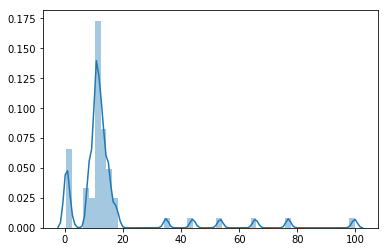

In [136]:
#same thing as above except by percentage of total missing nan
sns.distplot(mcz_percent)

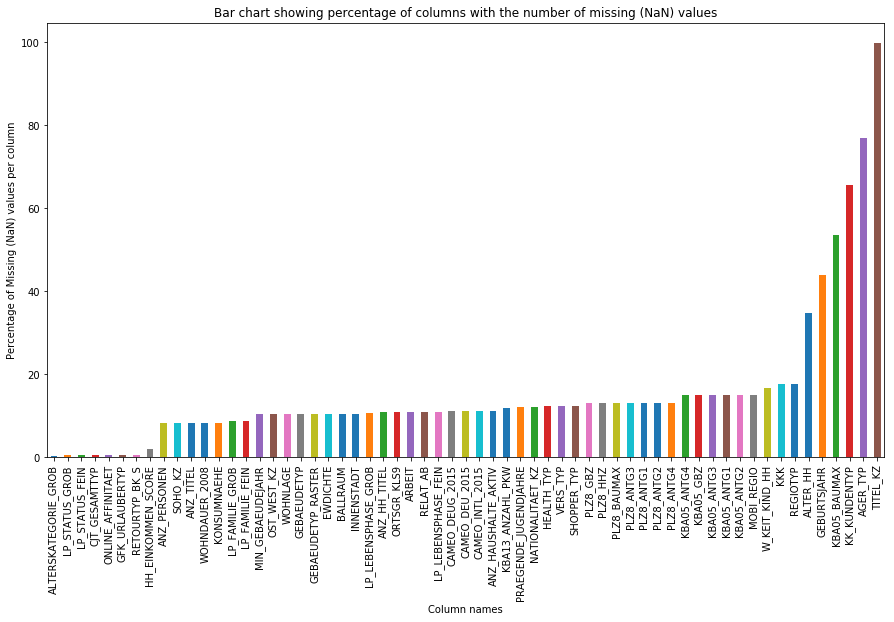

There are 61 columns with missing (NaN) values.


In [137]:
mcz_percent.plot.bar(figsize=(15,8))
plt.xlabel('Column names')
plt.ylabel('Percentage of Missing (NaN) values per column')
plt.title('Bar chart showing percentage of columns with the number of missing (NaN) values')
plt.show()
print("There are {} columns with missing (NaN) values.".format(len(mcz_percent)))

In [138]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

#creating percentage greather than 30% since a clear cutoff starts at ALTER_HH at 44%. 

mcz_greater_30 =[]
for col in azdias.columns:
    if (azdias[col].isnull().sum()/azdias.shape[0]) * 100 > 30:
        mcz_greater_30.append(col)

mcz_greater_30

#output is correct becauese there are 6 in chart and 6 for output, shape must be 0

['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

In [139]:
# dropping the mcz_greater_30 group from main DF and then printing off what was dropped for verificaiton purposes.
azdias = azdias.drop(mcz_greater_30,axis=1)
azdias.head()

print(f'{len(mcz_greater_30)} columns greater than 30% in missing column values were dropped')
print(f'{azdias.shape[1]} columns are remaining')

azdias.columns

6 columns greater than 30% in missing column values were dropped
79 columns are remaining


Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP',
       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
       'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S',
       'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT',
       'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT',
       'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ANZ_PERSONEN',
       'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015',
       'CAMEO

#### Discussion 1.1.2: Assess Missing Data in Each Column


The column with the largest missing value is TITEL_KZ with 99%. The column with the lowest missing value is ALTERSKATEGORIE_GROB with 0.323264%. A majority of the columns contain less than 20% of missing values. The columns that were removed are TITEL_KZ, AGER_TYP, KK_KUNDENTYP, KBA05_BAUMAX, GEBURTSJAHR, ALTER_HH and they were greater than 30%. These would be the outliers. 

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [140]:
# How much data is missing in each row of the dataset?

#checking the rows that have greater than 0 for missing values

missing_row_test = azdias.isnull().sum(axis=1)
missing_row_count = missing_row_test[missing_row_test > 0]
missing_row_count.sort_values(inplace=True, ascending=False)
missing_row_count

732775    49
643174    49
472919    48
604334    47
604314    47
768879    47
604319    47
604322    47
604323    47
275622    47
62901     47
275620    47
604332    47
275617    47
604305    47
275611    47
275610    47
62912     47
604335    47
604338    47
604346    47
604350    47
146293    47
604356    47
62887     47
768892    47
146291    47
348454    47
604091    47
604092    47
          ..
38561      1
768647     1
607245     1
709042     1
507663     1
607271     1
561427     1
235434     1
235435     1
235445     1
607405     1
62924      1
144785     1
91916      1
820005     1
607433     1
709002     1
38612      1
144760     1
561377     1
607469     1
423798     1
423777     1
507723     1
768704     1
736034     1
736038     1
768679     1
736043     1
237075     1
Length: 268012, dtype: int64

In [141]:
# calculating the percent of missing counts in a row
mrc_percent=missing_row_count.sort_values()/azdias.shape[1] * 100
mrc_percent

237075     1.265823
110252     1.265823
110249     1.265823
110232     1.265823
884377     1.265823
292273     1.265823
309312     1.265823
177403     1.265823
308874     1.265823
539502     1.265823
884695     1.265823
308889     1.265823
884661     1.265823
674335     1.265823
110352     1.265823
664958     1.265823
884622     1.265823
110346     1.265823
308975     1.265823
308988     1.265823
664952     1.265823
110302     1.265823
309043     1.265823
674239     1.265823
309051     1.265823
544336     1.265823
664919     1.265823
884646     1.265823
747312     1.265823
2775       1.265823
            ...    
526503    59.493671
839556    59.493671
839529    59.493671
453402    59.493671
527069    59.493671
453376    59.493671
839537    59.493671
183492    59.493671
527051    59.493671
288864    59.493671
183496    59.493671
221224    59.493671
183499    59.493671
318326    59.493671
453260    59.493671
221169    59.493671
27531     59.493671
527002    59.493671
318322    59.493671


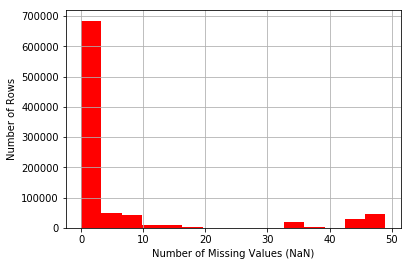

In [142]:
missing_row_count_visual =azdias.isnull().sum(axis=1)
plt.hist(missing_row_count_visual, bins=15, color='r')
plt.ylabel('Number of Rows')
plt.xlabel('Number of Missing Values (NaN)')
plt.grid(True)
plt.show()

In [143]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# splitting the main DF into 2 sets based on rows having at >= 30% of missing values using the same methods as before

mrc_low = azdias[azdias.isnull().sum(axis=1) < 30].reset_index(drop=True)
mrc_high = azdias[azdias.isnull().sum(axis=1) >= 30].reset_index(drop=True)

print(f'High missing row value is: {len(mrc_high)/len(azdias)*100},low missing row value is: {len(mrc_low)/len(azdias)*100}')

High missing row value is: 10.4530750509694,low missing row value is: 89.5469249490306


In [144]:
mrc_low.index, mrc_high.index

(RangeIndex(start=0, stop=798061, step=1),
 RangeIndex(start=0, stop=93160, step=1))

In [145]:
column_to_analyse = ['PLZ8_HHZ',  'LP_STATUS_FEIN', 'GFK_URLAUBERTYP', 'ZABEOTYP', 'ALTERSKATEGORIE_GROB'] #random

In [146]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def column_comparison(column):

    #plotting high
    fig = plt.figure(figsize=(12,4))
    ax1 = fig.add_subplot(121)
    ax1.title.set_text('Many NaN rows - MRC_High')
    sns.countplot(azdias.loc[mrc_high.index,column])
    
    #plotting low
    ax2 = fig.add_subplot(122)
    ax2.title.set_text('Few NaN rows - MRC_Low')
    sns.countplot(azdias.loc[~azdias.index.isin(mrc_low),column]);

    fig.suptitle(column)
    plt.show()


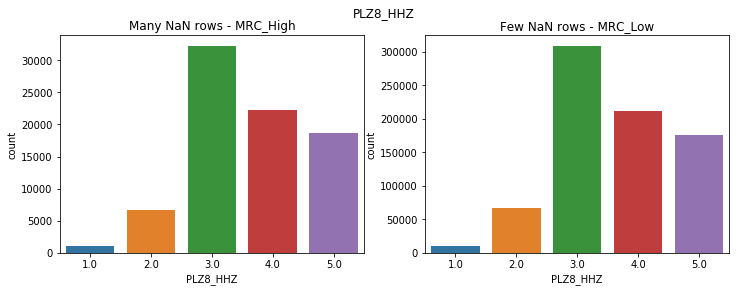

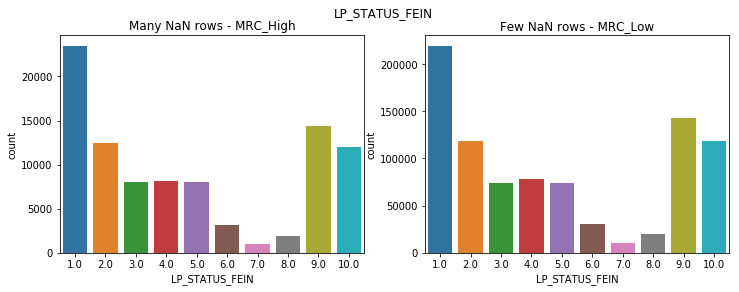

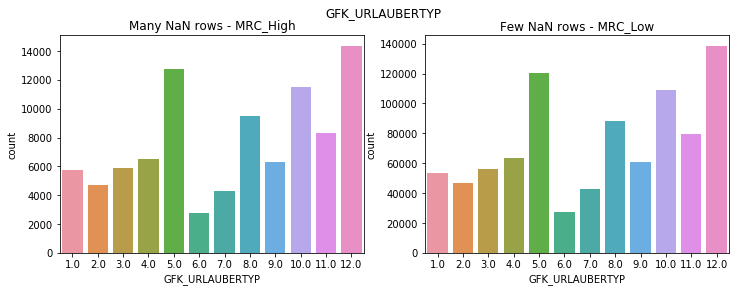

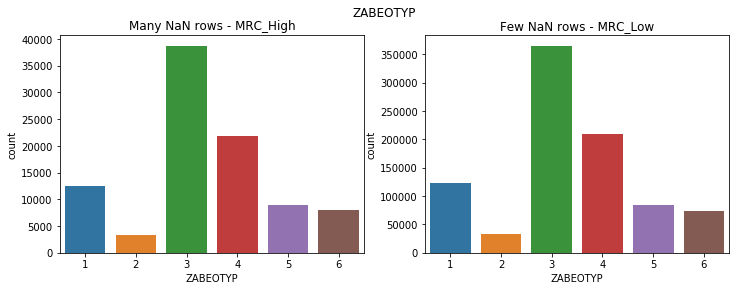

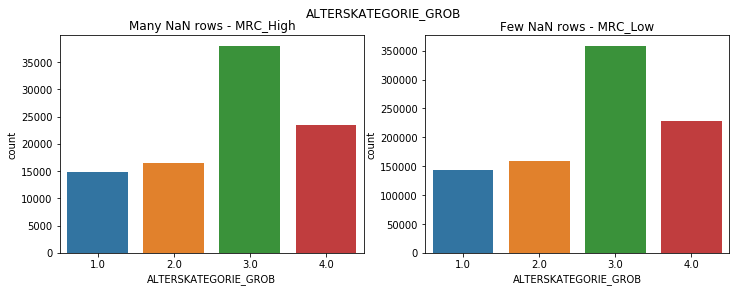

In [147]:
for column in column_to_analyse:
    column_comparison(column)

In [148]:
# selecting rows with high missing values
azdias_several_missing = azdias.iloc[mrc_high.index]

print(f'Total rows in azdias dataset is {azdias.shape[0]}')

Total rows in azdias dataset is 891221


In [149]:
# dropping rows with high missing values/counts (11.6%)
azdias = azdias[~azdias.index.isin(mrc_high.index)]
azdias.head()

print(f'{len(azdias_several_missing)} rows greater than 30% in missing row values were dropped')
print(f'{azdias.shape[0]} rows are remaining')

93160 rows greater than 30% in missing row values were dropped
798061 rows are remaining


#### Discussion 1.1.3: Assess Missing Data in Each Row

Based on the charts above, there are some rows that are similar and others quite different. About 11.7% (93160/798061) of the total rows contain more than 30% of missing values. Because of this, I dropped those rows to remove that potential pitfall. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [150]:
# How many features are there of each data type?
feat_info['type'].value_counts()


ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

In [151]:
#checking out the data, datatypes
feat_info.type.dtypes

dtype('O')

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [152]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

categorical_columns = feat_info.loc[feat_info['type'] == 'categorical', 'attribute'].values


In [153]:
categorical_columns

array(['AGER_TYP', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP',
       'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
       'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ',
       'VERS_TYP', 'ZABEOTYP', 'KK_KUNDENTYP', 'GEBAEUDETYP',
       'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'], dtype=object)

In [154]:
# selecting the categorical columns in azdias using the cell above for finding it

categorical_columns = [categorical_columns for categorical_columns in categorical_columns if categorical_columns in azdias.columns] 
categorical_columns

['ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [155]:
# Re-encode categorical variable(s) to be kept in the analysis.

binary_columns = []
multiple_columns = []
for column in categorical_columns:
    if azdias[column].nunique() > 2:
        multiple_columns.append(column)
    else:
        binary_columns.append(column)


In [156]:
binary_columns

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

In [157]:
multiple_columns

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [158]:
#funky column
azdias['OST_WEST_KZ'].unique()

array(['O', 'W', nan], dtype=object)

In [159]:
# dropping the multilevel categorical columns and making it overwrite
azdias.drop(multiple_columns, axis=1, inplace=True)

In [160]:
azdias.shape

(798061, 66)

In [161]:
# checking unique values in categorical binary column but now I see that we have a W, O like above, so it must change
for col in binary_columns:
    print(azdias[col].value_counts())

2    416483
1    381578
Name: ANREDE_KZ, dtype: int64
0    640911
1    157150
Name: GREEN_AVANTGARDE, dtype: int64
0.0    726425
1.0      6170
Name: SOHO_KZ, dtype: int64
2.0    356877
1.0    342022
Name: VERS_TYP, dtype: int64
W    562845
O    152061
Name: OST_WEST_KZ, dtype: int64


In [162]:
# converting categorical binary variables with non-numeric values to numeric, basically standardizing these from OneHotEncoder
azdias.loc[:, 'OST_WEST_KZ'].replace({'W':'0', 'O':'1'}, inplace=True)

In [163]:
# checking the column values and data types again to see if it has been changed to binary
for col in binary_columns:
    print(azdias[col].value_counts())

2    416483
1    381578
Name: ANREDE_KZ, dtype: int64
0    640911
1    157150
Name: GREEN_AVANTGARDE, dtype: int64
0.0    726425
1.0      6170
Name: SOHO_KZ, dtype: int64
2.0    356877
1.0    342022
Name: VERS_TYP, dtype: int64
0    562845
1    152061
Name: OST_WEST_KZ, dtype: int64


#### Discussion 1.2.1: Re-Encode Categorical Features

Removed multilevel categorical features then manually encoded OST_WEST_KZ to 0,1. Then dropped all multiple level features

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [164]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

azdias[['PRAEGENDE_JUGENDJAHRE']].head()

,PRAEGENDE_JUGENDJAHRE
93160,3.0
93161,7.0
93162,8.0
93163,14.0
93164,14.0


In [165]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

#creating functions to changed those in () to return 1-6 to standarize what is displayed in those columns
def encode_intervals(x): #define_parse
    if x in (1,2):
        return 1
    elif x in (3,4):
        return 2
    elif x in (5,6,7):
        return 3
    elif x in (8,9):
        return 4
    elif x in (10,11,12,13):
        return 5
    elif x in (14,15):
        return 6

In [166]:
#creating function based on the location of where it falls in the define_interval funciton to be binary results
def encode_movements (x): #define_binary
    if x in (2,4,6,7,9,11,13,15):
        return 0
    elif x in (1,3,5,8,10,12,14):
        return 1

In [167]:
#creating two columns and applying the two functions

azdias['DECADES'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(encode_intervals)
azdias['MOVEMENTS'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(encode_movements)

In [168]:
azdias['DECADES'].value_counts().sort_index()

1.0     25819
2.0     67891
3.0    104095
4.0    160580
5.0    135923
6.0    207280
Name: DECADES, dtype: int64

In [169]:
azdias['MOVEMENTS'].value_counts().sort_index()

0.0    157150
1.0    544438
Name: MOVEMENTS, dtype: int64

In [170]:
# Dropping 'PRAEGENDE_JUGENDJAHRE' column from the dataframe
azdias = azdias.drop('PRAEGENDE_JUGENDJAHRE',axis=1)

In [171]:
azdias[['CAMEO_INTL_2015']].head()

,CAMEO_INTL_2015
93160,43
93161,15
93162,45
93163,54
93164,43


In [172]:
# Adding a feature based on wealth
def encode_wealth(x):
    if x // 10 ==1:
        return 1
    if x // 10 ==2:
        return 2
    if x // 10 ==3:
        return 3
    if x // 10 ==4:
        return 4
    if x // 10 ==5:
        return 5

# Adding a feature based on lfe stage
def encode_life_stage(x):
    if x % 10 ==1:
        return 1
    if x % 10 ==2:
        return 2
    if x % 10 ==3:
        return 3
    if x % 10 ==4:
        return 4
    if x % 10 ==5:
        return 5

In [173]:
azdias['CAMEO_INTL_2015'].dtypes

dtype('O')

In [174]:
# converting CAMEO_INTL_2015 to numerics
azdias['CAMEO_INTL_2015'] = pd.to_numeric(azdias['CAMEO_INTL_2015'])

In [175]:
# adding WEALTH'  and 'LIFE_STAGE' based on wealth and stage of life using the functions above

azdias['WEALTH'] = azdias['CAMEO_INTL_2015'].apply(encode_wealth)
azdias['LIFE_STAGE'] = azdias['CAMEO_INTL_2015'].apply(encode_life_stage)

#dropping the column
azdias.drop('CAMEO_INTL_2015', axis=1, inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

1) Created two 4 variables called decades, movement, wealth, life stage 

2) Applied the functions to the azdias dataframe to replace what matches

3) Dropped Cameo Intl 2015 & PRAEGENDE_JUGENDJAHRE

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [176]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

np.unique(azdias.dtypes.values)

array([dtype('int64'), dtype('float64'), dtype('O')], dtype=object)

In [177]:
# who has the dtypes of strict O

# notes: row 93185 does have NaN
azdias.loc[:, azdias.dtypes == 'O']

,OST_WEST_KZ
93160,1
93161,1
93162,1
93163,1
93164,1
93165,1
93166,1
93167,0
93168,0
93169,0


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [178]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    
    Really putting everything done above into a single function
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...    
    for i,item in zip(range(len(df)), df.iteritems()): #zip is needed to keep tuple shape with range
        missing_unknown = feat_info['missing_or_unknown'][i]
        missing_unknown = missing_unknown[1:-1].split(',') #as noted from above cell
        column_name = item[0]
        if missing_unknown != ['']:
            miss = [x if x in ['X','XX'] else int(x) for x in missing_unknown] #some have X, XX. 
            
            df[column_name] = df[column_name].replace(miss,np.nan)
              
            
   
    
    # removing selected columns i.e. rows having > 30% of missing values
    df = df.drop(['AGER_TYP','GEBURTSJAHR','TITEL_KZ','ALTER_HH','KK_KUNDENTYP','KBA05_BAUMAX'],axis=1)
    

    # removing selected rows i.e. rows having > 30% of missing values
    missing_row_count = df.isnull().sum(axis=1)
    missing_row_count.value_counts().sort_index(ascending=False,inplace=True)
    
    # dividing the rows into 2 subsets based on having missing value less than 30% or not <
    mrc_low = df[df.isnull().sum(axis=1)<30].reset_index(drop=True)
    mrc_high = df[df.isnull().sum(axis=1)>=30].reset_index(drop=True)
    
    # selecting rows with high missing values
    df_several_missing = df.iloc[mrc_high.index]
    print(f'Total rows in dataset is {df.shape[0]}')
    
  

    # dropping rows with high missing values
    df = df[~df.index.isin(mrc_high.index)]
    print(f'{len(df_several_missing)} rows greater than 30% in missing row values were dropped')
    print(f'{df.shape[0]} rows are remaining')
       
    
    # select, re-encode, and engineer column values.
    # dropping the multilevel categorical columns
    for column in df.columns:
        if column in multiple_columns:
            df.drop(column, axis=1, inplace=True)
             
   
    # encoding the 'OST_WEST_KZ' binary categorical column
    df.loc[:, 'OST_WEST_KZ'].replace({'W':'0', 'O':'1'}, inplace=True) 
    
    # Engineering(converting) "PRAEGENDE_JUGENDJAHRE" and 'CAMEO_INTL_2015'into two new variables each     
    # adding 2 new columns "DECADES" and 'MOVEMENTS' based on decade of birth and movement
    df['DECADES'] = df['PRAEGENDE_JUGENDJAHRE'].apply(encode_intervals)
    df['MOVEMENTS'] = df['PRAEGENDE_JUGENDJAHRE'].apply(encode_movements)
    
    # Dropping 'PRAEGENDE_JUGENDJAHRE' column from the dataframe
    df = df.drop('PRAEGENDE_JUGENDJAHRE',axis=1)
    
    
        
    # Adding 2 new features based on wealth and life stage and dropping 'CAMEO_INTL_2015'
    df['CAMEO_INTL_2015'] = pd.to_numeric(df['CAMEO_INTL_2015'])
    
    df['wealth'] = df['CAMEO_INTL_2015'].apply(encode_wealth)
    df['life_stage'] = df['CAMEO_INTL_2015'].apply(encode_life_stage)
    df.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    
    
    column_list = df.columns
       
    # impute NaN | selecting mean for replacing missing values in each column rather than "most_frequent"
    # imputer = Imputer(strategy='mean', axis=0) 
    # df = imputer.fit_transform(df)
    # df = pd.DataFrame(df, columns=column_list)
    
    print('Done')

    # Return the cleaned dataframe.
    return df, df_several_missing
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [179]:
# copying azdias for a new dataframe
azdias_copy=azdias.copy()
column_list = azdias_copy.columns

In [180]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
imputer = Imputer(strategy='mean', axis=0)
azdias_copy = imputer.fit_transform(azdias_copy)

In [181]:
# checking for missing values but we want to see all zeros
azdias_copy = pd.DataFrame(azdias_copy, columns= column_list)
azdias_copy.isnull().sum()

ALTERSKATEGORIE_GROB     0
ANREDE_KZ                0
FINANZ_MINIMALIST        0
FINANZ_SPARER            0
FINANZ_VORSORGER         0
FINANZ_ANLEGER           0
FINANZ_UNAUFFAELLIGER    0
FINANZ_HAUSBAUER         0
GREEN_AVANTGARDE         0
HEALTH_TYP               0
LP_LEBENSPHASE_FEIN      0
LP_LEBENSPHASE_GROB      0
RETOURTYP_BK_S           0
SEMIO_SOZ                0
SEMIO_FAM                0
SEMIO_REL                0
SEMIO_MAT                0
SEMIO_VERT               0
SEMIO_LUST               0
SEMIO_ERL                0
SEMIO_KULT               0
SEMIO_RAT                0
SEMIO_KRIT               0
SEMIO_DOM                0
SEMIO_KAEM               0
SEMIO_PFLICHT            0
SEMIO_TRADV              0
SOHO_KZ                  0
VERS_TYP                 0
ANZ_PERSONEN             0
                        ..
OST_WEST_KZ              0
WOHNLAGE                 0
KBA05_ANTG1              0
KBA05_ANTG2              0
KBA05_ANTG3              0
KBA05_ANTG4              0
K

In [182]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler()
azdias_scaled = scaler.fit_transform(azdias_copy)
azdias_scaled = pd.DataFrame(azdias_scaled, columns= column_list)
azdias_scaled.head()

#NOTES: we have 68 features/columns 

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADES,MOVEMENTS,WEALTH,LIFE_STAGE
0,1.231412,0.957179,1.454051,-1.241620,0.453026,-0.675111,-1.259957,0.684390,-0.495175,-0.268112,...,-0.692964,-1.774003,-0.367319,-0.176995,-1.052862,-0.832891,-1.703722,0.573007,0.536028,0.089457
1,0.240123,-1.044737,1.454051,-1.241620,0.453026,-1.329063,-1.259957,-0.053970,2.019490,1.146826,...,-0.692964,0.427850,-0.367319,0.882833,1.245454,-0.054110,-0.973237,-1.985153,-1.636902,1.518387
2,0.240123,0.957179,0.697641,0.123572,-0.302845,0.632794,-0.587234,-1.530689,-0.495175,1.146826,...,-0.692964,-1.774003,-0.367319,-0.176995,-0.593198,-0.832891,-0.242752,0.573007,0.536028,1.518387
3,-0.751165,-1.044737,-1.571589,1.488764,-1.058716,1.286746,0.758211,1.422749,-0.495175,1.146826,...,0.777350,0.427850,-0.367319,0.882833,-0.133535,-0.054110,1.218218,0.573007,1.260338,0.803922
4,-0.751165,0.957179,-0.815179,1.488764,-1.058716,1.286746,0.085488,0.684390,-0.495175,-1.683050,...,-0.692964,-1.774003,-0.367319,-0.176995,-1.972188,-0.832891,1.218218,0.573007,0.536028,0.089457


### Discussion 2.1: Apply Feature Scaling


I imputed the missing (nan) values with the mean of the columns. I selected this as it reduces the chances of creating outliers and assumes that missing values would fall into the mean. 

Afterwards, I scaled all features using standard scaler fit_transform to mean 0 and standard deviation 1.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [183]:
# Apply PCA to the data.
pca = PCA(whiten= True)
pca_features = pca.fit_transform(azdias_scaled)
pd.DataFrame(pca_features)

,0,1,2,3,4,5,6,7,8,9,...,58,59,60,61,62,63,64,65,66,67
0,-0.798892,1.388954,-0.505207,-0.660795,0.683353,-1.281655,0.734902,-1.547718,0.120419,-0.236398,...,-0.131001,0.432933,0.068949,-1.756560,1.553867,0.502438,-0.862548,-0.164524,-0.425406,-0.886129
1,-0.689347,0.872358,0.982557,1.763106,0.148761,-1.687299,-0.555573,2.011777,0.336690,0.345617,...,0.291010,0.399651,0.206677,1.098490,0.039459,-0.254308,0.131675,-0.029364,1.185084,-0.633473
2,-1.182179,-0.179367,-1.063167,-0.141120,2.722845,-0.182616,0.361272,0.499897,2.184808,0.598054,...,2.036994,0.521842,1.389168,0.180356,1.573760,-2.697732,-1.790334,-0.052206,-2.074894,0.865548
3,1.382530,-1.115816,1.124085,-0.739182,-0.790433,-0.185841,-0.450581,-2.889249,0.832689,0.112001,...,1.535347,-1.222966,0.086689,-0.054613,0.481243,-1.622620,1.354743,-1.498705,-1.153423,-0.484798
4,-0.460898,-1.322260,-1.231314,-2.030032,0.606524,-1.663635,0.832371,-0.699465,-1.384082,1.323290,...,-0.022447,0.566872,0.617392,0.459702,-0.283790,-1.057828,-1.911539,-1.639273,-0.710052,-0.651603
5,-0.602200,-1.064805,-0.521439,0.073223,-1.328640,0.104080,0.271957,1.176807,0.941153,-0.145642,...,0.079940,-0.217253,-0.392917,-1.005545,1.828667,0.311858,1.540875,0.141058,0.131968,0.436953
6,-1.560219,0.459062,1.154895,-1.901391,0.639962,-2.049288,1.179713,-0.432668,-1.162798,0.411128,...,-0.441186,0.708249,0.491323,0.530038,-1.994457,0.026541,-0.661674,0.599226,0.437183,-1.024592
7,-1.257305,-1.993545,1.429824,-0.429085,1.737240,0.518068,0.227185,0.915203,-1.199898,0.081323,...,-0.403088,1.764534,0.825944,1.661448,1.007793,-0.819909,-2.723387,-1.321449,-1.211677,0.113088
8,-0.965496,0.320463,-0.639453,2.768253,0.713000,1.180443,-0.446218,-0.080760,1.084408,0.084501,...,2.314601,0.890237,-0.580213,-1.109933,-0.671319,0.939591,-1.533349,0.199409,-0.896654,-0.886270
9,-0.430268,0.664175,-0.649208,1.754522,0.093279,1.710694,-0.200994,-0.992678,0.900359,-0.773990,...,-0.106091,-0.249887,-1.079010,-0.635062,-0.476537,1.300506,-1.856148,1.001897,-1.803424,-0.065909


In [184]:
#selecting first column 2nd row
pd.DataFrame(pca_features)[0][1]

-0.6893474678009307

In [185]:
# explained variance for each component
pca.explained_variance_ratio_

array([  1.70005766e-01,   1.23067301e-01,   8.70677901e-02,
         5.45804823e-02,   4.02818275e-02,   3.27235615e-02,
         3.03152204e-02,   2.53889320e-02,   2.28427892e-02,
         2.13629113e-02,   2.08274493e-02,   1.96331736e-02,
         1.89681673e-02,   1.77372676e-02,   1.75175241e-02,
         1.57465961e-02,   1.54595438e-02,   1.47043903e-02,
         1.33880175e-02,   1.24166671e-02,   1.22362867e-02,
         1.14185580e-02,   1.12867064e-02,   1.08496483e-02,
         1.05972935e-02,   9.52457823e-03,   9.43919161e-03,
         8.35886430e-03,   7.50655709e-03,   7.17559538e-03,
         6.89223984e-03,   6.70688983e-03,   6.40587732e-03,
         6.24987145e-03,   6.07837898e-03,   5.83184080e-03,
         5.59461528e-03,   5.23122940e-03,   4.69816718e-03,
         4.47306249e-03,   4.35704902e-03,   4.05764073e-03,
         3.98684291e-03,   3.82329287e-03,   3.65908517e-03,
         3.63451904e-03,   3.47045019e-03,   3.36707085e-03,
         3.14173079e-03,

In [186]:
# cummulative explained variance
np.cumsum(pca.explained_variance_ratio_)

array([ 0.17000577,  0.29307307,  0.38014086,  0.43472134,  0.47500317,
        0.50772673,  0.53804195,  0.56343088,  0.58627367,  0.60763658,
        0.62846403,  0.6480972 ,  0.66706537,  0.68480264,  0.70232016,
        0.71806676,  0.7335263 ,  0.74823069,  0.76161871,  0.77403538,
        0.78627166,  0.79769022,  0.80897693,  0.81982658,  0.83042387,
        0.83994845,  0.84938764,  0.8577465 ,  0.86525306,  0.87242866,
        0.8793209 ,  0.88602779,  0.89243366,  0.89868354,  0.90476191,
        0.91059376,  0.91618837,  0.9214196 ,  0.92611777,  0.93059083,
        0.93494788,  0.93900552,  0.94299236,  0.94681566,  0.95047474,
        0.95410926,  0.95757971,  0.96094678,  0.96408851,  0.96705765,
        0.96999188,  0.97272702,  0.97530828,  0.9778251 ,  0.98024616,
        0.98260671,  0.98478037,  0.98690787,  0.98894163,  0.99081752,
        0.99262127,  0.99437419,  0.99595232,  0.99745836,  0.99865074,
        0.99981464,  0.99992504,  1.        ])

In [187]:
num_components = len(pca.explained_variance_ratio_)
num_components
# we still have 68 features/columns

68

In [188]:
pca_features.sum(axis=0)

array([  1.33733380e-09,  -4.43347403e-09,  -1.82994597e-09,
         4.75495199e-11,  -1.64533276e-10,   3.18252091e-11,
         1.34235734e-10,  -4.96960695e-10,  -3.74576814e-10,
         6.19692742e-10,   3.29606564e-10,   5.37312417e-10,
         8.59770921e-10,  -2.27061037e-10,  -2.75448997e-10,
         3.83863608e-10,   5.21353627e-10,   6.94484470e-11,
        -1.18869536e-09,   7.82662823e-11,   3.02719627e-10,
         1.28224542e-10,  -5.07455411e-10,   9.37831146e-10,
        -2.52369148e-09,  -1.75639059e-10,  -1.48008183e-09,
         9.15946430e-10,  -1.09547216e-09,  -1.35621292e-09,
        -1.05909237e-09,  -1.75017334e-09,   2.17704965e-09,
         9.26128507e-10,  -3.82139831e-09,  -1.68794401e-09,
         1.30813760e-09,   1.01753272e-09,   3.16404680e-10,
        -1.67965197e-09,  -2.29676544e-09,  -8.43428438e-10,
        -1.63685954e-09,   2.49251819e-09,   3.25968585e-09,
        -3.63947095e-10,  -2.70192402e-09,   7.65780328e-10,
         2.79138135e-09,

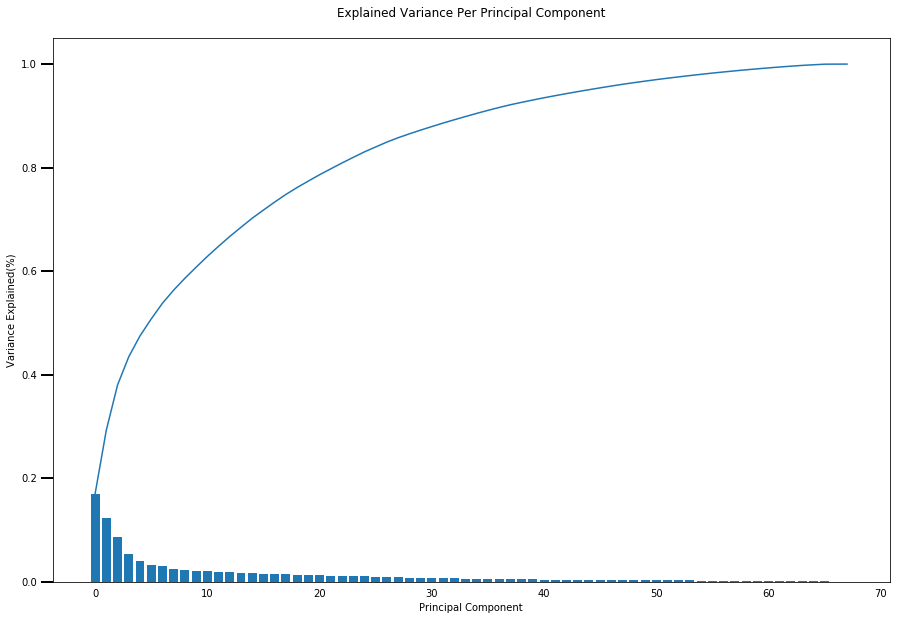

In [189]:
# Investigate the variance accounted for by each principal component.
def plot(pca):
    num_components = len(pca.explained_variance_ratio_)
    index = np.arange(num_components)
    values = pca.explained_variance_ratio_
 
    plt.figure(figsize=(15, 10))
    ax = plt.subplot()
    cumvalues = np.cumsum(values)
    ax.bar(index, values)
    ax.plot(index, cumvalues)
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained(%)")
    plt.title('Explained Variance Per Principal Component\n')


plot(pca)

In [190]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(20)
pca_featuresV2 = pca.fit_transform(azdias_scaled)
pd.DataFrame(pca_featuresV2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-2.716280,4.018040,-1.229245,-1.273343,1.130865,-1.915548,1.054587,-2.034955,0.151638,-0.275265,0.181318,0.518681,-0.887218,-0.483569,-0.621247,1.188202,0.028845,-0.094644,0.451551,0.469912
1,-2.343821,2.523608,2.390786,3.396706,0.246587,-2.515638,-0.797360,2.647018,0.428822,0.411044,-0.942804,1.409665,-2.249055,-0.049125,-0.521953,1.125838,2.034799,-0.051780,-0.632568,0.495225
2,-4.019477,-0.518885,-2.586948,-0.271770,4.506737,-0.268913,0.516874,0.651166,2.709668,0.714561,-0.405403,0.010168,-1.244264,0.059736,0.237049,0.909199,-0.287812,-0.077288,0.370585,0.055418
3,4.700683,-3.227896,2.735151,-1.423910,-1.308530,-0.278871,-0.645965,-3.791691,1.050900,0.138840,0.022383,2.343003,-0.519661,0.163185,-0.389703,0.570238,0.604740,-0.115230,0.193366,0.688486
4,-1.567076,-3.825089,-2.996079,-3.910986,1.004836,-2.478081,1.193788,-0.917468,-1.733975,1.588518,-0.869610,1.025552,1.080640,-2.080555,-0.529938,1.037931,0.610671,-0.069296,1.099881,-1.059054
5,-2.047515,-3.080310,-1.268781,0.140933,-2.198210,0.156552,0.389696,1.546290,1.164424,-0.175646,-2.235028,0.940102,-2.570497,-1.103020,-0.014850,2.445549,0.855868,0.050957,0.489586,1.110568
6,-5.304835,1.328006,2.810142,-3.663229,1.059593,-3.057085,1.692922,-0.573749,-1.459566,0.490509,-1.291790,0.044133,-0.832307,0.050083,-0.355822,0.606288,0.766068,-0.081902,0.722202,0.062145
7,-4.274914,-5.767036,3.479116,-0.826748,2.874419,0.770601,0.327557,1.202384,-1.489727,0.104543,0.636692,-0.594438,0.627300,-0.028128,-0.607414,0.778031,0.972990,-0.127870,0.064435,1.323900
8,-3.282746,0.927046,-1.555911,5.332920,1.179503,1.761026,-0.639912,-0.108179,1.345093,0.109060,0.675284,0.209048,-1.384719,0.270161,0.025784,-0.869335,0.007635,-0.136545,-0.005921,-0.208962
9,-1.462936,1.921361,-1.579698,3.380301,0.154702,2.553545,-0.289196,-1.307330,1.119411,-0.937391,1.749813,0.138678,-1.313984,-1.245373,0.122679,-1.963183,0.761376,-0.059442,-0.838862,0.349931


### Discussion 2.2: Perform Dimensionality Reduction

From the plot above, I observed that at 20 components, about 80% of the variance explained in the dataset. Plus i also want this to run/finish in a timely mannor. Any longer and we sacrific accuracy with speed and "depending" on how we use this data, it could be an issue. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [191]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def weights_of_pca_features(pca, i):
    weight_map = {}
    for counter, feature in enumerate(azdias_scaled.columns):
        weight_map[feature] = pca.components_[i][counter]
    
    weights_sorted = sorted(weight_map.items(), key=operator.itemgetter(1), reverse=True)
    
    return weights_sorted

In [192]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

weights_pc0 = weights_of_pca_features(pca, 0)
weights_pc0

[('PLZ8_ANTG3', 0.22850501530976775),
 ('PLZ8_ANTG4', 0.22273630526723198),
 ('PLZ8_BAUMAX', 0.2180566073965719),
 ('WEALTH', 0.2030021578792148),
 ('ORTSGR_KLS9', 0.20123627386059431),
 ('EWDICHTE', 0.19898268135791347),
 ('HH_EINKOMMEN_SCORE', 0.17475680500358673),
 ('FINANZ_HAUSBAUER', 0.16347211107956186),
 ('PLZ8_ANTG2', 0.15456045048842629),
 ('KBA05_ANTG4', 0.15306177280793237),
 ('ARBEIT', 0.1441927047535593),
 ('RELAT_AB', 0.13582700526047889),
 ('ANZ_HAUSHALTE_AKTIV', 0.13581149853962066),
 ('KBA05_ANTG3', 0.1321648763602753),
 ('FINANZ_SPARER', 0.10882856479888503),
 ('MOVEMENTS', 0.098680429219256238),
 ('SEMIO_PFLICHT', 0.08177939472540724),
 ('SEMIO_REL', 0.074633173259106775),
 ('REGIOTYP', 0.067758863530799698),
 ('SEMIO_RAT', 0.06677113310153962),
 ('DECADES', 0.065973786501731913),
 ('W_KEIT_KIND_HH', 0.058391052415476277),
 ('SEMIO_MAT', 0.056560868584242203),
 ('SEMIO_FAM', 0.055852627697405739),
 ('SEMIO_TRADV', 0.055674620661596091),
 ('OST_WEST_KZ', 0.05513734888

In [193]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weights_pc1 = weights_of_pca_features(pca, 1)
weights_pc1

[('ALTERSKATEGORIE_GROB', 0.2790012171640493),
 ('FINANZ_VORSORGER', 0.25879541266107497),
 ('SEMIO_ERL', 0.22834273351757778),
 ('SEMIO_LUST', 0.19019219240800028),
 ('RETOURTYP_BK_S', 0.17232721243768598),
 ('W_KEIT_KIND_HH', 0.12302905196463802),
 ('FINANZ_MINIMALIST', 0.11140415525310442),
 ('FINANZ_HAUSBAUER', 0.090192972656939721),
 ('WOHNDAUER_2008', 0.070304228096292984),
 ('EWDICHTE', 0.065793249393821973),
 ('ORTSGR_KLS9', 0.064654063744698578),
 ('PLZ8_ANTG3', 0.061682677979885435),
 ('SEMIO_KRIT', 0.059799732322340024),
 ('PLZ8_ANTG4', 0.058822033569205907),
 ('SEMIO_KAEM', 0.055430708407651838),
 ('PLZ8_BAUMAX', 0.054468746713069484),
 ('ANREDE_KZ', 0.051932314020714257),
 ('ARBEIT', 0.048295996523930726),
 ('RELAT_AB', 0.046472629510627111),
 ('KBA05_ANTG4', 0.046090298144654228),
 ('HH_EINKOMMEN_SCORE', 0.045021941522456442),
 ('WEALTH', 0.044143358230672697),
 ('ANZ_HAUSHALTE_AKTIV', 0.043198892698409562),
 ('PLZ8_ANTG2', 0.042513191745127951),
 ('VERS_TYP', 0.030984790

In [194]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weights_pc2 = weights_of_pca_features(pca, 2)
weights_pc2

[('SEMIO_VERT', 0.35408535976131295),
 ('SEMIO_SOZ', 0.29041088117464314),
 ('SEMIO_KULT', 0.28227228847341229),
 ('SEMIO_FAM', 0.23813891140874199),
 ('FINANZ_MINIMALIST', 0.13838072438890983),
 ('RETOURTYP_BK_S', 0.078550067166403323),
 ('SEMIO_MAT', 0.068676602471476625),
 ('FINANZ_VORSORGER', 0.06392993445813773),
 ('W_KEIT_KIND_HH', 0.063299192953173933),
 ('GREEN_AVANTGARDE', 0.062239672788483337),
 ('SEMIO_REL', 0.060412612728120756),
 ('ALTERSKATEGORIE_GROB', 0.040161898804787204),
 ('PLZ8_BAUMAX', 0.035447647517233567),
 ('PLZ8_ANTG4', 0.032267594492960995),
 ('ORTSGR_KLS9', 0.031813479068882246),
 ('PLZ8_ANTG3', 0.030739494168662458),
 ('EWDICHTE', 0.030057940904742505),
 ('ARBEIT', 0.024320662960953629),
 ('RELAT_AB', 0.021150672836518832),
 ('WOHNDAUER_2008', 0.020418415268712881),
 ('PLZ8_ANTG2', 0.019594494405334287),
 ('HH_EINKOMMEN_SCORE', 0.019265839729119494),
 ('SEMIO_LUST', 0.017424744649391803),
 ('WEALTH', 0.016790712212986145),
 ('KBA05_ANTG4', 0.0158677451860424

### Discussion 2.3: Interpret Principal Components


The list of strongest positive feature weights within the principal components of 1 - 3 are:

1) PLZ8_ANTG3 & PLZ8_ANTG4 (Number of 6-10 family houses in the PLZ8_ANTG3 & Number of 10+ family houses in the PLZ8 region)

    1.A) Essentually we are seeing the highest (positive) correlation with their size of family "houses". The top 3 are 6-10, 10+ and then after it's the 1-5 range of famly size or unknown. Basically it's great to see the top 3 PCA in weights_pca0 because family size does matter when breaking into customer segements. Seeing the strong correlation across the 3 options is encouraging. 

2) ALTERSKATEGORIE_GROB (Estimated age based on given name analysis)
   
    2.A) I'm seeing the highest (positive) correlation with their estimated age description and that makes sense given that age tends to match well with trying to segement customers. This is from the weights_pc1 dataframe

3) SEMIO_VERT (Personality typology, for each dimension)
    
    3.A) There are 4 additional SEMIO components at the top of weights_pc2 that have the highest (postive) correlation with each of their description of personality. Again, these are positive to see as those compoents would be helpful when building customer segments.


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [195]:
def k_mean_score(data, n_cluster):
    kmeans = KMeans(n_clusters = n_cluster)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score

import time
time_begin = time.time()

scores = []
k_clusters = [x for x in range(2,10,2)]
for k in k_clusters:
    scores.append(k_mean_score(pca_featuresV2, k))
    print(f'Run time: {round(((time.time()-time_begin)/60), 3)} mins')

In [196]:
import time
time_begin = time.time()

scores = []
k_clusters = [x for x in range(2,25,2)]
for k in k_clusters:
    scores.append(k_mean_score(pca_featuresV2, k))
    print(f'Run time: {round(((time.time()-time_begin)/60), 3)} mins')

Run time: 0.238 mins
Run time: 0.738 mins
Run time: 1.399 mins
Run time: 2.804 mins
Run time: 4.983 mins
Run time: 8.056 mins
Run time: 10.973 mins
Run time: 17.396 mins
Run time: 22.741 mins
Run time: 28.411 mins
Run time: 35.95 mins
Run time: 42.217 mins


In [197]:
scores

[35520728.562806599,
 29906364.301795162,
 27080187.384913456,
 25308170.398010861,
 23863275.656272776,
 22673462.443059526,
 21823675.586113717,
 21240720.733925335,
 20753625.416191131,
 19871688.741545811,
 19428967.595124703,
 19043572.193506669]

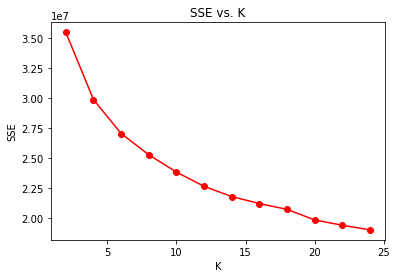

In [198]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(k_clusters, scores, linestyle='-', marker='o', color='r');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');


# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

time_begin = time.time()
kmeans = KMeans(n_clusters=5)
model_v2 = kmeans.fit(pca_featuresV2)
predict_general = model_v2.predict(pca_featuresV2)

print(f'Run time: {round(((time.time()-time_begin)/60), 3)} mins')

In [199]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

time_begin = time.time()
kmeans = KMeans(n_clusters=20)
model_v2 = kmeans.fit(pca_featuresV2)
predict_general = model_v2.predict(pca_featuresV2)

print(f'Run time: {round(((time.time()-time_begin)/60), 3)} mins')

Run time: 4.693 mins


In [200]:
predict_general

array([19, 14,  2, ..., 17, 16,  0], dtype=int32)

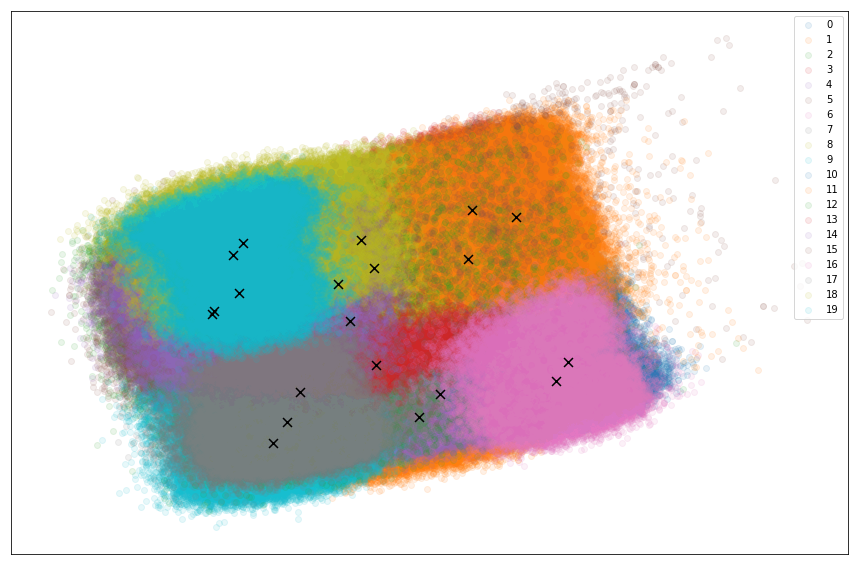

In [201]:
general_labels = model_v2.predict(pca_featuresV2)
unique_general_labels = np.unique(general_labels)

plt.figure(figsize=[15,10])
for i in unique_general_labels:
    plt.scatter(pca_featuresV2[general_labels == i , 0] , pca_featuresV2[general_labels == i , 1] , label = i, alpha=0.1)

centroids = model_v2.cluster_centers_
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'black', marker='x')
plt.xticks(())
plt.yticks(())
plt.legend();

### Discussion 3.1: Apply Clustering to General Population (UPDATED)

After running the model and displaying the plot above, I selected 20 as the elbow and it's also quicker to run than continuing to loop through to 15 or 20.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [205]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

In [206]:
customers.shape

(191652, 85)

In [207]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

#calling the clean_data function at the way top. 

# customers_clean = clean_data(customers)

customers_clean, customer_several_missing  = clean_data(customers)

Total rows in dataset is 191652
49927 rows greater than 30% in missing row values were dropped
141725 rows are remaining
Done


In [208]:
# impute NaN | selecting mean for replacing missing values in each column rather than "most_frequent"

customers_clean_imputed = pd.DataFrame(imputer.transform(customers_clean))
customers_clean_imputed.columns = customers_clean.columns
customers_clean_imputed.index = customers_clean.index

In [209]:
customers_clean_imputed.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADES,MOVEMENTS,wealth,life_stage
49927,1.0,2.0,2.0,5.0,3.0,5.0,5.0,3.0,0.0,2.189487,...,1.000000,4.000000,4.00000,4.000000,7.000000,5.00000,4.332316,0.776008,1.000000,3.000000
49928,3.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,0.0,2.189487,...,1.942607,3.611373,3.38074,3.167003,5.290507,3.06948,4.332316,0.776008,3.259947,2.874792
49929,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,0.0,2.000000,...,1.000000,4.000000,5.00000,4.000000,3.000000,5.00000,1.000000,1.000000,1.000000,5.000000
49930,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,1.000000,...,1.000000,4.000000,4.00000,3.000000,6.000000,2.00000,2.000000,0.000000,1.000000,5.000000
49931,4.0,2.0,2.0,1.0,5.0,1.0,1.0,5.0,0.0,1.000000,...,4.000000,3.000000,2.00000,3.000000,7.000000,5.00000,3.000000,1.000000,3.000000,1.000000


In [210]:
customers_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADES,MOVEMENTS,wealth,life_stage
49927,1.0,2,2,5,3,5,5,3,0,NaN,...,1.0,4.0,4.0,4.0,7.0,5.0,NaN,NaN,1.0,3.0
49928,3.0,2,3,4,3,5,5,3,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49929,4.0,1,5,1,5,1,2,2,0,2.0,...,1.0,4.0,5.0,4.0,3.0,5.0,1.0,1.0,1.0,5.0
49930,4.0,1,5,1,5,1,2,2,1,1.0,...,1.0,4.0,4.0,3.0,6.0,2.0,2.0,0.0,1.0,5.0
49931,4.0,2,2,1,5,1,1,5,0,1.0,...,4.0,3.0,2.0,3.0,7.0,5.0,3.0,1.0,3.0,1.0


In [211]:
customers_clean_imputed.shape[1]

68

In [212]:
customers_clean.shape[1]
#still have 68. This is positive.

68

In [213]:
len(customers_clean)

141725

In [214]:
# scaling,standarizing, and transforming it without using fit_transform. 
# Everything matches based on this to then use inverse

# updated after review

customers_std = scaler.transform(customers_clean_imputed)
customers_std = pd.DataFrame(customers_std, columns = list(customers_clean_imputed))
pca_customers = pca.transform(customers_std)
predict_customers = model_v2.predict(pca_customers)

COMMENTED OUT AFTER THE 1st review
### scaling,standarizing, and transforming it without using fit_transform. 
### Everything matches based on this to then use inverse

customers_std = scaler.transform(customers_clean)
pca_customers = pca.transform(customers_std)
predict_customers = model_v2.predict(pca_customers)

In [215]:
pca_customers

array([[  8.86316912e-01,  -1.36725275e+00,  -2.64678648e+00, ...,
         -1.01119479e-01,   2.75527252e-03,   2.27161162e-01],
       [  1.29420351e-01,  -1.67074397e+00,  -2.29998337e+00, ...,
          1.81528801e-02,  -7.24346503e-01,  -3.11509400e-01],
       [ -4.88074247e+00,   1.65960217e+00,   2.87352223e+00, ...,
         -9.21826337e-02,  -8.17096931e-01,   8.68276759e-01],
       ..., 
       [ -4.73934176e+00,   3.70265384e+00,   2.31589890e+00, ...,
         -1.66501542e-01,  -2.69207649e-01,   6.66057342e-01],
       [ -1.21414216e+00,   2.69915595e+00,  -2.11648661e+00, ...,
         -1.37479283e-01,  -3.15865889e-01,  -2.33345153e-01],
       [ -4.84919621e+00,  -2.04544752e+00,   2.75430736e+00, ...,
         -1.05103600e-01,  -8.86164355e-02,  -2.09550266e-01]])

In [216]:
predict_customers

array([13, 13,  5, ..., 14,  8,  5], dtype=int32)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [217]:
# number of persons in each cluster based off of predictions in general dataset 
predicted_general_customer_number = pd.Series(predict_general).value_counts().sort_index() 
predicted_general_customer_number

0     53476
1     42664
2     34253
3     42287
4     47546
5     55008
6     48370
7     24986
8     50936
9     42264
10    40334
11    36973
12     6136
13    72809
14    48561
15     3380
16    35005
17    38663
18    37729
19    36681
dtype: int64

In [218]:
# number of persons in each cluster based off of predictions in customer dataset 
predicted_customer_number = pd.Series(predict_customers).value_counts().sort_index()
predicted_customer_number

0      9519
1       556
2      4668
3      4547
4       582
5     15356
6      6009
7      1132
8      5462
9      2283
10      593
11     4138
12     1035
13    34282
14    33055
15     2302
16      674
17      772
18    10593
19     4167
dtype: int64

In [219]:
# creating dataframe for each cluster and the no of person belonging 
# to each cluster for both general and customers data
df_both = pd.concat([predicted_general_customer_number, predicted_customer_number], axis=1).reset_index()
df_both.columns = ['clusters', 'predict_general', 'predict_customers']
df_both

,clusters,predict_general,predict_customers
0,0,53476,9519
1,1,42664,556
2,2,34253,4668
3,3,42287,4547
4,4,47546,582
5,5,55008,15356
6,6,48370,6009
7,7,24986,1132
8,8,50936,5462
9,9,42264,2283


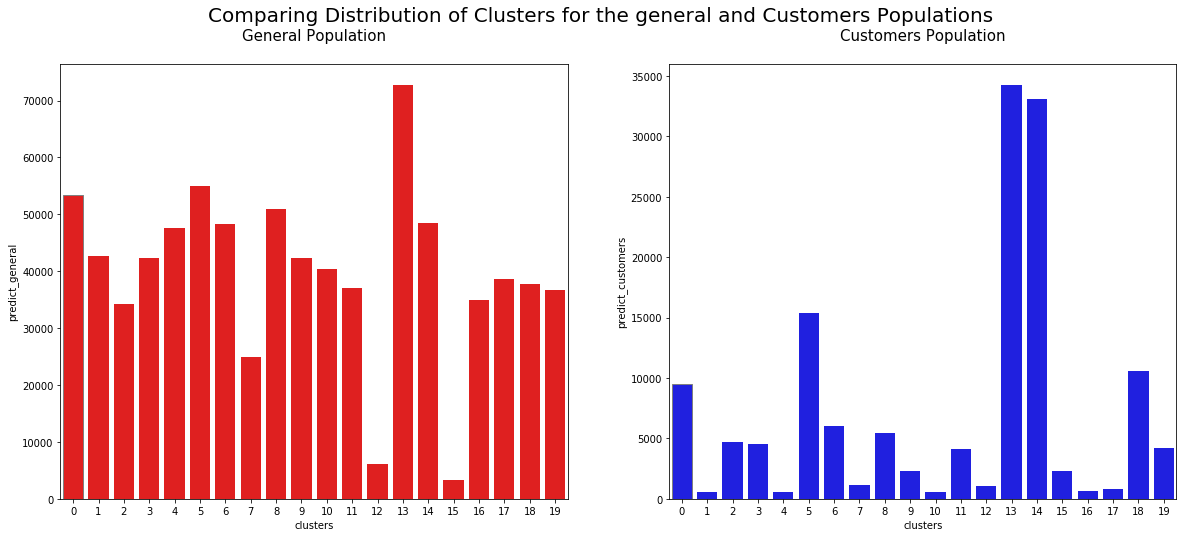

In [220]:
# Visualize dataframe as bar charts
fig = plt.figure(figsize=(20,8))

ax1 = fig.add_subplot(1,2,1)
ax1 = sns.barplot(x='clusters',y='predict_general', data=df_both, color='r',edgecolor='.5')
plt.title("General Population\n", fontsize=15)

ax2 = fig.add_subplot(1,2,2)
ax2 = sns.barplot(x='clusters',y='predict_customers', data=df_both,color='b',edgecolor='.5')
plt.title("Customers Population\n", fontsize=15)
plt.suptitle("Comparing Distribution of Clusters for the general and Customers Populations\n", fontsize=20);

In [221]:
# calculating proportions of persons in both customer and general data
df_both['general_proportions'] = (df_both['predict_general']/df_both['predict_general'].sum()*100).round(3)
df_both['customers_proportions'] = (df_both['predict_customers']/df_both['predict_customers'].sum()*100).round(3)

# calculating the diferences between the two proportions
df_both['difference'] = df_both['general_proportions'] - df_both['customers_proportions']
df_both

,clusters,predict_general,predict_customers,general_proportions,customers_proportions,difference
0,0,53476,9519,6.701,6.717,-0.016
1,1,42664,556,5.346,0.392,4.954
2,2,34253,4668,4.292,3.294,0.998
3,3,42287,4547,5.299,3.208,2.091
4,4,47546,582,5.958,0.411,5.547
5,5,55008,15356,6.893,10.835,-3.942
6,6,48370,6009,6.061,4.240,1.821
7,7,24986,1132,3.131,0.799,2.332
8,8,50936,5462,6.382,3.854,2.528
9,9,42264,2283,5.296,1.611,3.685


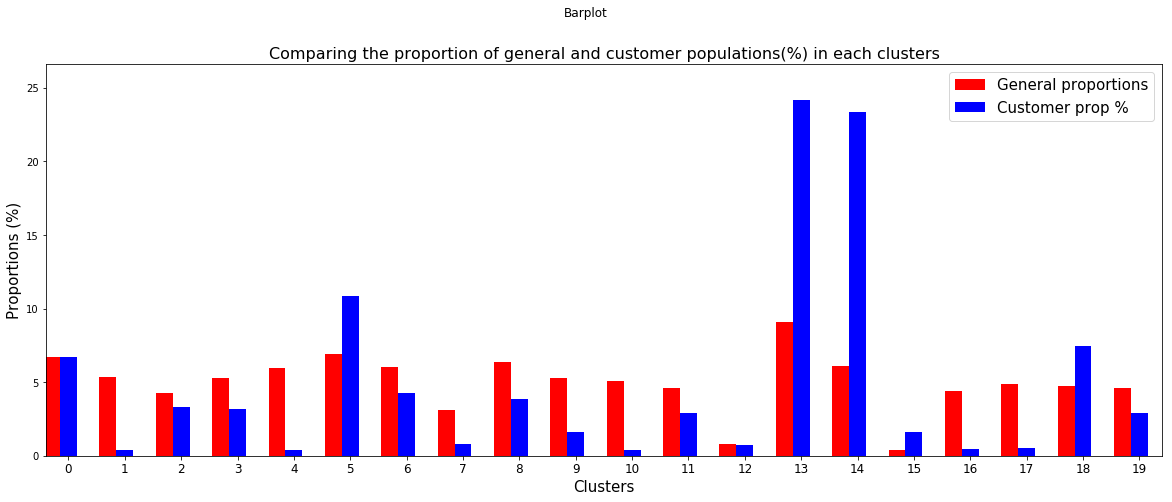

In [222]:
fig = plt.figure(figsize=(20,8))

ax = fig.add_subplot(1,1,1)

ax = df_both['general_proportions'].plot(x=df_both['clusters'], kind='bar',color='r',width=-0.3, align='edge',position=0)
ax = df_both['customers_proportions'].plot(x=df_both['clusters'], kind='bar',color='b',width = 0.3, align='edge',position=1)

ax.margins(x=0.5,y=0.1)
ax.set_xlabel('Clusters', fontsize=15) 
ax.set_ylabel('Proportions (%)', fontsize=15)
ax.xaxis.set(ticklabels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
ax.tick_params(axis = 'x', labelsize = 12)
plt.xticks(rotation=360,)

plt.legend(('General proportions', 'Customer prop %'),fontsize=15)
plt.title('Comparing the proportion of general and customer populations(%) in each clusters',fontsize=16)

plt.subplots_adjust(bottom=0.2)
plt.suptitle("Barplot", fontsize=12)
plt.show()

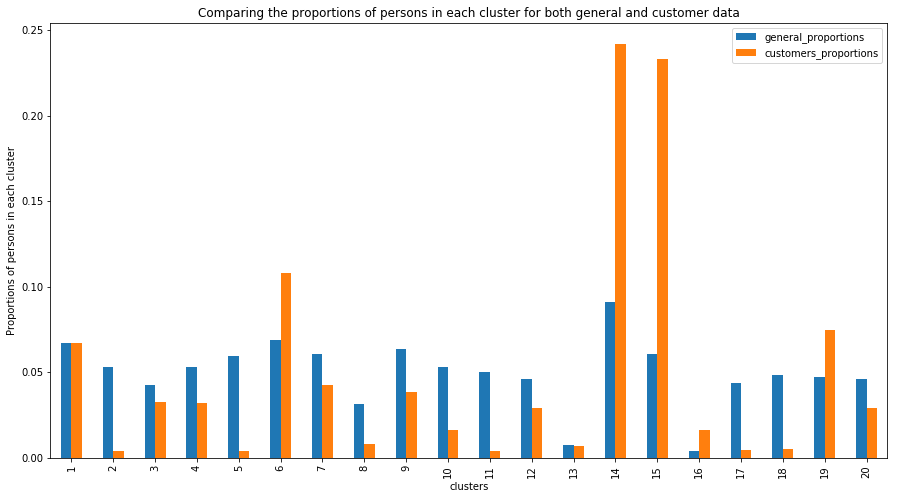

In [223]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

general_proportions2 = []
customers_proportions2 = []
x = [i+1 for i in range(20)]
for i in range(20):
    general_proportions2.append((predict_general == i).sum()/len(predict_general))
    customers_proportions2.append((predict_customers == i).sum()/len(predict_customers))


df_props = pd.DataFrame({'clusters' : x, 'general_proportions' : general_proportions2, 'customers_proportions':customers_proportions2})


df_props.plot(x='clusters', y = ['general_proportions', 'customers_proportions'], kind='bar', figsize=(15,8))
plt.ylabel('Proportions of persons in each cluster')
plt.title('Comparing the proportions of persons in each cluster for both general and customer data')
plt.show()

In [224]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
general_data = scaler.inverse_transform(pca.inverse_transform(pca_featuresV2[np.where(predict_general==2)])).round(2)
general_data = pd.DataFrame(general_data, columns=azdias.columns)

general_data.head()

#still good to see 68 columns 

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADES,MOVEMENTS,WEALTH,LIFE_STAGE
0,2.77,1.98,3.54,2.67,2.70,3.97,1.68,2.16,0.02,3.10,...,1.14,2.43,3.05,3.49,3.40,2.51,5.22,1.03,2.15,3.87
1,3.28,1.82,4.12,2.31,3.57,3.20,2.88,1.70,0.07,1.45,...,1.57,5.16,5.02,1.68,2.93,1.06,4.32,0.91,2.24,2.71
2,3.12,1.26,3.71,3.70,2.52,4.22,3.90,1.26,0.00,2.33,...,0.36,2.79,3.79,2.61,3.20,2.52,5.52,0.97,1.97,3.71
3,3.62,1.92,5.05,0.86,4.88,2.37,1.83,1.04,0.14,2.02,...,0.56,2.77,3.62,2.11,1.82,1.72,3.17,0.83,2.14,3.11
4,3.23,1.93,3.18,3.05,3.31,3.40,3.57,2.41,0.06,2.38,...,1.90,3.00,2.94,3.03,4.99,3.80,4.65,0.89,2.53,4.25


In [225]:
customer_data = scaler.inverse_transform(pca.inverse_transform(pca_customers[np.where(predict_customers==2)])).round(2)
customer_data=pd.DataFrame(customer_data, columns=azdias.columns)
customer_data.head()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADES,MOVEMENTS,WEALTH,LIFE_STAGE
0,2.93,2.03,3.94,2.37,3.70,3.09,2.86,1.90,1.02,1.96,...,0.66,3.05,3.78,2.59,4.56,2.66,4.50,-0.01,1.95,3.14
1,4.26,2.05,3.42,1.35,4.66,2.30,1.36,3.74,0.07,1.29,...,1.81,5.11,4.87,1.77,1.65,1.67,3.12,0.93,3.77,1.52
2,3.79,1.77,4.77,1.31,4.36,2.36,1.74,1.60,0.18,1.73,...,1.19,5.15,5.27,1.04,2.15,0.10,3.66,0.84,1.68,3.13
3,3.95,1.72,3.74,2.69,3.70,3.77,3.12,2.31,0.03,1.50,...,1.51,1.37,2.04,2.25,3.37,2.24,4.19,0.92,2.76,3.02
4,3.73,1.92,4.28,0.80,5.34,2.00,1.12,2.78,0.08,2.28,...,0.86,5.15,5.14,2.13,3.68,1.72,2.85,0.93,2.06,4.53


In [226]:
# defining functions to scale and do pca
def get_sorted_weights(x):
      
    x = scaler.transform(x)
    x = pca.transform(x)
    
    return x

In [227]:
get_sorted_weights(general_data)

# getting wiehhts of pca
weights_of_pca_features(pca, 0)

[('PLZ8_ANTG3', 0.22850501530976775),
 ('PLZ8_ANTG4', 0.22273630526723198),
 ('PLZ8_BAUMAX', 0.2180566073965719),
 ('WEALTH', 0.2030021578792148),
 ('ORTSGR_KLS9', 0.20123627386059431),
 ('EWDICHTE', 0.19898268135791347),
 ('HH_EINKOMMEN_SCORE', 0.17475680500358673),
 ('FINANZ_HAUSBAUER', 0.16347211107956186),
 ('PLZ8_ANTG2', 0.15456045048842629),
 ('KBA05_ANTG4', 0.15306177280793237),
 ('ARBEIT', 0.1441927047535593),
 ('RELAT_AB', 0.13582700526047889),
 ('ANZ_HAUSHALTE_AKTIV', 0.13581149853962066),
 ('KBA05_ANTG3', 0.1321648763602753),
 ('FINANZ_SPARER', 0.10882856479888503),
 ('MOVEMENTS', 0.098680429219256238),
 ('SEMIO_PFLICHT', 0.08177939472540724),
 ('SEMIO_REL', 0.074633173259106775),
 ('REGIOTYP', 0.067758863530799698),
 ('SEMIO_RAT', 0.06677113310153962),
 ('DECADES', 0.065973786501731913),
 ('W_KEIT_KIND_HH', 0.058391052415476277),
 ('SEMIO_MAT', 0.056560868584242203),
 ('SEMIO_FAM', 0.055852627697405739),
 ('SEMIO_TRADV', 0.055674620661596091),
 ('OST_WEST_KZ', 0.05513734888

In [228]:
get_sorted_weights(customer_data)

# getting wiehhts of pca
weights_of_pca_features(pca, 1)

[('ALTERSKATEGORIE_GROB', 0.2790012171640493),
 ('FINANZ_VORSORGER', 0.25879541266107497),
 ('SEMIO_ERL', 0.22834273351757778),
 ('SEMIO_LUST', 0.19019219240800028),
 ('RETOURTYP_BK_S', 0.17232721243768598),
 ('W_KEIT_KIND_HH', 0.12302905196463802),
 ('FINANZ_MINIMALIST', 0.11140415525310442),
 ('FINANZ_HAUSBAUER', 0.090192972656939721),
 ('WOHNDAUER_2008', 0.070304228096292984),
 ('EWDICHTE', 0.065793249393821973),
 ('ORTSGR_KLS9', 0.064654063744698578),
 ('PLZ8_ANTG3', 0.061682677979885435),
 ('SEMIO_KRIT', 0.059799732322340024),
 ('PLZ8_ANTG4', 0.058822033569205907),
 ('SEMIO_KAEM', 0.055430708407651838),
 ('PLZ8_BAUMAX', 0.054468746713069484),
 ('ANREDE_KZ', 0.051932314020714257),
 ('ARBEIT', 0.048295996523930726),
 ('RELAT_AB', 0.046472629510627111),
 ('KBA05_ANTG4', 0.046090298144654228),
 ('HH_EINKOMMEN_SCORE', 0.045021941522456442),
 ('WEALTH', 0.044143358230672697),
 ('ANZ_HAUSHALTE_AKTIV', 0.043198892698409562),
 ('PLZ8_ANTG2', 0.042513191745127951),
 ('VERS_TYP', 0.030984790

In [229]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
general_data_v2 = scaler.inverse_transform(pca.inverse_transform(pca_featuresV2[np.where(predict_general==1)])).round(2)
general_data_v2 = pd.DataFrame(general_data_v2, columns=azdias.columns)
general_data_v2.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADES,MOVEMENTS,WEALTH,LIFE_STAGE
0,1.81,0.99,0.88,5.02,1.27,4.53,3.95,5.22,-0.01,1.96,...,3.31,3.95,2.81,4.01,5.14,3.47,5.83,0.98,4.42,3.13
1,1.33,0.77,2.30,4.89,2.05,4.68,4.59,3.04,0.04,2.32,...,1.13,4.06,4.01,3.98,5.28,4.42,6.05,0.93,3.18,4.45
2,1.44,0.93,0.85,5.46,1.70,4.33,4.67,4.05,0.01,2.02,...,1.73,4.22,3.84,3.90,7.51,4.26,6.61,0.99,4.84,1.47
3,2.01,1.11,1.71,4.31,1.85,4.03,3.55,3.67,0.10,1.96,...,1.37,4.50,4.26,4.44,5.86,3.95,5.69,0.88,4.20,1.89
4,1.51,0.77,2.58,4.47,2.20,3.97,3.55,2.73,0.04,2.64,...,1.73,2.79,3.00,3.34,5.29,3.53,6.08,0.98,4.40,0.79


In [230]:
customer_data_v2 = scaler.inverse_transform(pca.inverse_transform(pca_customers[np.where(predict_customers==1)])).round(2)
customer_data_v2 = pd.DataFrame(customer_data_v2, columns=azdias.columns)
customer_data_v2.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADES,MOVEMENTS,WEALTH,LIFE_STAGE
0,2.09,0.69,3.28,3.11,3.75,3.01,3.12,2.85,0.04,2.89,...,1.73,2.92,2.84,3.11,5.11,3.31,4.16,0.90,4.20,2.07
1,2.22,0.71,4.26,2.37,3.52,1.82,2.45,1.82,0.03,2.04,...,2.17,3.71,3.34,3.05,5.25,3.16,4.25,0.98,3.21,2.76
2,1.91,0.96,3.51,2.65,4.08,2.16,2.82,2.91,0.95,2.17,...,2.35,4.23,3.49,2.93,6.63,3.07,4.01,0.03,4.22,1.09
3,1.29,0.93,1.46,4.48,1.90,4.31,3.51,5.07,-0.13,1.92,...,2.83,4.57,3.38,4.50,7.14,3.65,5.29,1.11,3.70,4.65
4,2.47,1.28,2.02,4.39,2.33,4.00,4.35,2.76,-0.12,2.79,...,2.10,5.70,4.86,1.69,4.43,1.36,5.77,1.07,3.01,2.91


In [231]:
get_sorted_weights(general_data_v2)

# getting wiehhts of pca
weights_of_pca_features(pca, 0)

[('PLZ8_ANTG3', 0.22850501530976775),
 ('PLZ8_ANTG4', 0.22273630526723198),
 ('PLZ8_BAUMAX', 0.2180566073965719),
 ('WEALTH', 0.2030021578792148),
 ('ORTSGR_KLS9', 0.20123627386059431),
 ('EWDICHTE', 0.19898268135791347),
 ('HH_EINKOMMEN_SCORE', 0.17475680500358673),
 ('FINANZ_HAUSBAUER', 0.16347211107956186),
 ('PLZ8_ANTG2', 0.15456045048842629),
 ('KBA05_ANTG4', 0.15306177280793237),
 ('ARBEIT', 0.1441927047535593),
 ('RELAT_AB', 0.13582700526047889),
 ('ANZ_HAUSHALTE_AKTIV', 0.13581149853962066),
 ('KBA05_ANTG3', 0.1321648763602753),
 ('FINANZ_SPARER', 0.10882856479888503),
 ('MOVEMENTS', 0.098680429219256238),
 ('SEMIO_PFLICHT', 0.08177939472540724),
 ('SEMIO_REL', 0.074633173259106775),
 ('REGIOTYP', 0.067758863530799698),
 ('SEMIO_RAT', 0.06677113310153962),
 ('DECADES', 0.065973786501731913),
 ('W_KEIT_KIND_HH', 0.058391052415476277),
 ('SEMIO_MAT', 0.056560868584242203),
 ('SEMIO_FAM', 0.055852627697405739),
 ('SEMIO_TRADV', 0.055674620661596091),
 ('OST_WEST_KZ', 0.05513734888

In [232]:
get_sorted_weights(customer_data_v2)

# getting weights of pca
weights_of_pca_features(pca, 0)

[('PLZ8_ANTG3', 0.22850501530976775),
 ('PLZ8_ANTG4', 0.22273630526723198),
 ('PLZ8_BAUMAX', 0.2180566073965719),
 ('WEALTH', 0.2030021578792148),
 ('ORTSGR_KLS9', 0.20123627386059431),
 ('EWDICHTE', 0.19898268135791347),
 ('HH_EINKOMMEN_SCORE', 0.17475680500358673),
 ('FINANZ_HAUSBAUER', 0.16347211107956186),
 ('PLZ8_ANTG2', 0.15456045048842629),
 ('KBA05_ANTG4', 0.15306177280793237),
 ('ARBEIT', 0.1441927047535593),
 ('RELAT_AB', 0.13582700526047889),
 ('ANZ_HAUSHALTE_AKTIV', 0.13581149853962066),
 ('KBA05_ANTG3', 0.1321648763602753),
 ('FINANZ_SPARER', 0.10882856479888503),
 ('MOVEMENTS', 0.098680429219256238),
 ('SEMIO_PFLICHT', 0.08177939472540724),
 ('SEMIO_REL', 0.074633173259106775),
 ('REGIOTYP', 0.067758863530799698),
 ('SEMIO_RAT', 0.06677113310153962),
 ('DECADES', 0.065973786501731913),
 ('W_KEIT_KIND_HH', 0.058391052415476277),
 ('SEMIO_MAT', 0.056560868584242203),
 ('SEMIO_FAM', 0.055852627697405739),
 ('SEMIO_TRADV', 0.055674620661596091),
 ('OST_WEST_KZ', 0.05513734888

### Discussion 3.3: Compare Customer Data to Demographics Data

A majority of the clusters have a strong relationship between prediction and general. The larger differences are in cluster 2 and 16. These two should be handeled differently than the rest of the clusters as they have a larger population percentage. 
opposite would be roughly clusters 1, 4,9,12,14 as they have a smaller percentage of customer population % and would be under represented. 

Clusters 3 and 17 have a large difference in proportions of person to general, indicating that it's saturated or over represented

When looking into the weights above we see that the top 3 components are family size, WEALTH and size of community. We gather that when taking these three components into consideration that we have a diverse family size, consistent wealth with a diverse size of community. Telling us that we would focus more on the size of the community for our mailings because they will are predicted to respond well to our sales and larger volumne usually means a better discount by mailer. the EWDICHTE (Density of households per square kilometer) compoent also relates well with this prediction because we would want to target the higher density of households per square kilometer. 

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.

In [233]:
# Done 